<a href="https://colab.research.google.com/github/romanbash/DTSA-5511-final/blob/main/pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***DTSA-5511: Final Project - Pokemon Type Detection***

## Github: https://github.com/romanbash/DTSA-5511-final

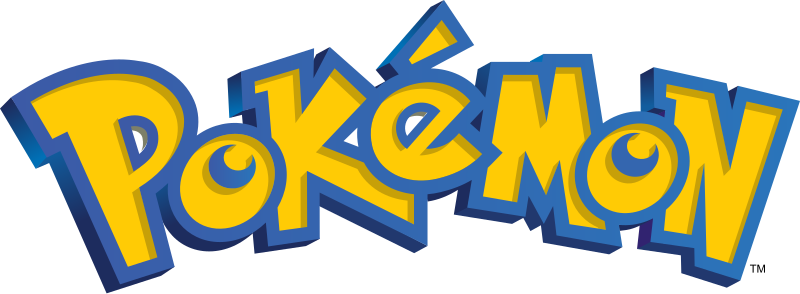

## Part 1: Brief Description of the Problem and Data

### Problem: Pokemon Type Detection using CNN

The challenge problem is to build a Convolutional Neural Networkmodel that can predict the type of a Pokemon based on its image. This is a multi-class classification problem, as a Pokemon can have one or two types (e.g., Fire, Water, Grass, Flying, etc.).

### Main Challenge

The main challenge is the limited size of the dataset, with only 809 images. This can lead to overfitting, where the model performs well on the training data but poorly on unseen data. Techniques like data augmentation and transfer learning can help address this issue.

### Data Characteristics

The data consists of:

* **Size**: 809 images of Pokemon.
* **Dimension**: Each image is 120x120 pixels.
* **Structure**: The images are stored in a folder structure, a CSV file with image names and corresponding labels.



First, Let's import all the packages we would use in our project.

In [1]:
import os
from PIL import Image
from google.colab import drive
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
import seaborn as sns
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB4
import matplotlib.pyplot as plt
from IPython.display import display, HTML
!pip install keras-tuner -q # Install Keras Tuner
import numpy as np
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00
Mounted at /content/drive


Let's check if the GPU works.

In [2]:
# Check for GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

# Specify the GPU device to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Enable GPU acceleration
tf.keras.backend.set_image_data_format('channels_last')
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

GPU is available


This hack if for quicker IO of pictures. We unzip all the data to "/content".

In [3]:
!unzip -q "/content/drive/MyDrive/DTSA 5511/final/pokemon.zip" -d "/content"

Let's check that the dataframe looks good.

In [4]:
pic_dir = "/content/images"
df = pd.read_csv('/content/pokemon.csv')

df

,Name,Type1,Type2,Evolution
0,bulbasaur,Grass,Poison,ivysaur
1,ivysaur,Grass,Poison,venusaur
2,venusaur,Grass,Poison,NaN
3,charmander,Fire,NaN,charmeleon
4,charmeleon,Fire,NaN,charizard
...,...,...,...,...
804,stakataka,Rock,Steel,NaN
805,blacephalon,Fire,Ghost,NaN
806,zeraora,Electric,NaN,NaN
807,meltan,Steel,NaN,NaN


# Exploratory Data Analysis

Let's look at some examples of pockemon and the data about them in the CSV file.


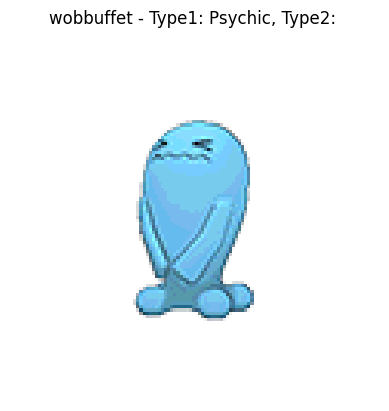

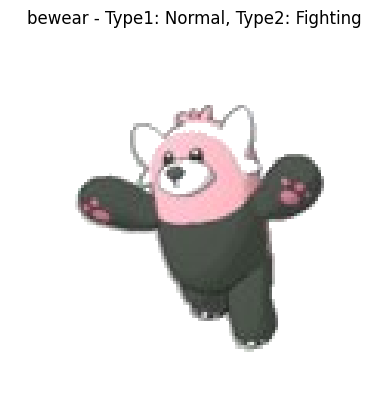

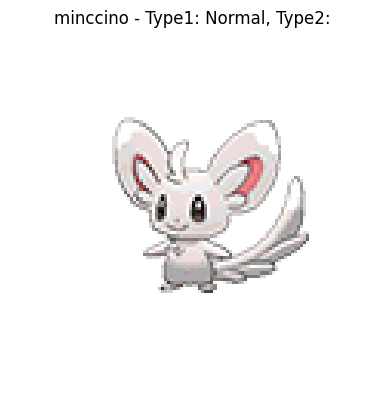

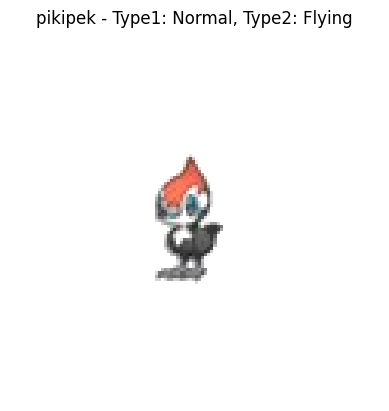

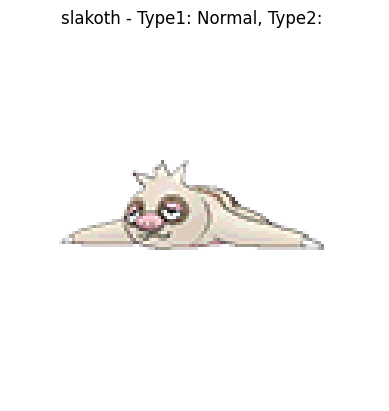

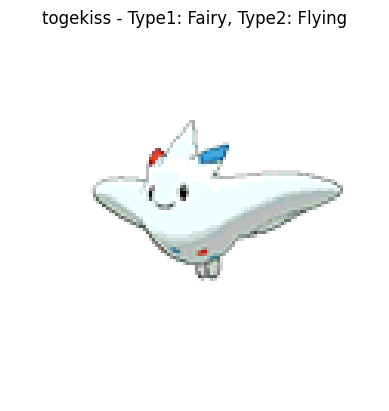

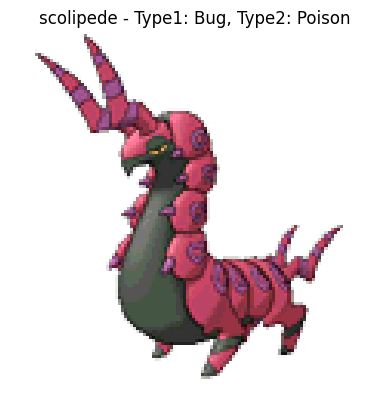

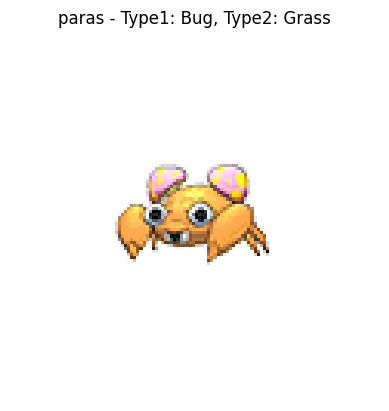

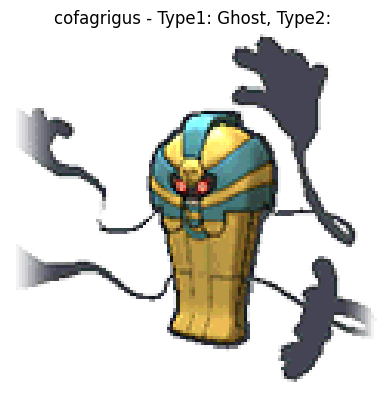

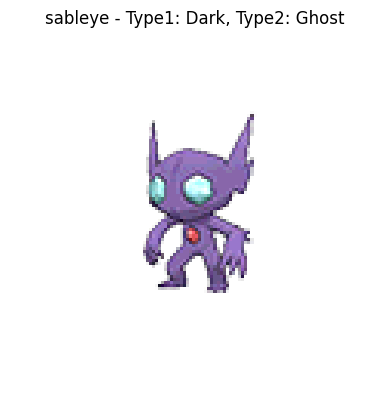

In [5]:
def show_pokemon_examples(df, pic_dir, num_examples=10):
  """Displays a specified number of random Pokemon examples with their types."""

  pokemon_names = df['Name'].tolist()
  random_pokemon = random.sample(pokemon_names, min(num_examples, len(pokemon_names)))

  for pokemon_name in random_pokemon:
    try:
      pokemon_data = df[df['Name'] == pokemon_name]
      type1 = pokemon_data['Type1'].iloc[0]
      type2 = pokemon_data['Type2'].iloc[0] if not pd.isnull(pokemon_data['Type2'].iloc[0]) else ''
      image_path = os.path.join(pic_dir, pokemon_name + '.png')

      if os.path.exists(image_path):
        img = Image.open(image_path)
        plt.imshow(img)
        plt.title(f"{pokemon_name} - Type1: {type1}, Type2: {type2}")
        plt.axis('off')
        plt.show()
      else:
        print(f"Image not found for {pokemon_name}")
    except Exception as e:
      print(f"Error processing {pokemon_name}: {e}")


# Call the function to show 5 random examples
show_pokemon_examples(df, pic_dir)

Some basic inforamtion about our data.

In [6]:
print(df.info())  # Data types, non-null counts
print(df.describe())  # Summary statistics for numerical features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       809 non-null    object
 1   Type1      809 non-null    object
 2   Type2      405 non-null    object
 3   Evolution  32 non-null     object
dtypes: object(4)
memory usage: 25.4+ KB
None
            Name  Type1   Type2 Evolution
count        809    809     405        32
unique       809     18      18        32
top     melmetal  Water  Flying   ivysaur
freq           1    114      95         1


Let's see if we have some missing data.

Name           0
Type1          0
Type2        404
Evolution    777
dtype: int64


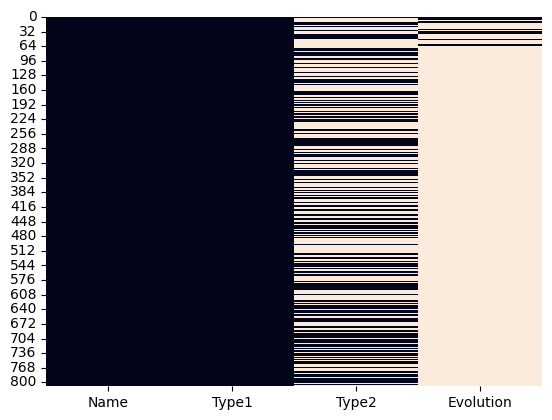

In [7]:
# 2. Missing Values
print(df.isnull().sum())  # Check for missing values in each column
# Visualize missing values (optional)
sns.heatmap(df.isnull(), cbar=False)
plt.show()

We can see that not all of the pokemons have two types and not all of them have evoluation.

Now let's explore the unique values in each type and count them.

In [8]:
# 3. Unique Values and Counts
types = ['Type1','Type2']
for column in types:
    print(f"Unique values in {column}: {df[column].nunique()}")
    print(df[column].value_counts())

Unique values in Type1: 18
Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Dragon       27
Ghost        27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: count, dtype: int64
Unique values in Type2: 18
Type2
Flying      95
Poison      32
Ground      32
Fairy       29
Psychic     29
Fighting    25
Steel       23
Grass       19
Dragon      18
Water       17
Dark        17
Ghost       16
Rock        14
Ice         11
Fire        11
Electric     8
Bug          5
Normal       4
Name: count, dtype: int64


Now let's explore the distribution of the values.

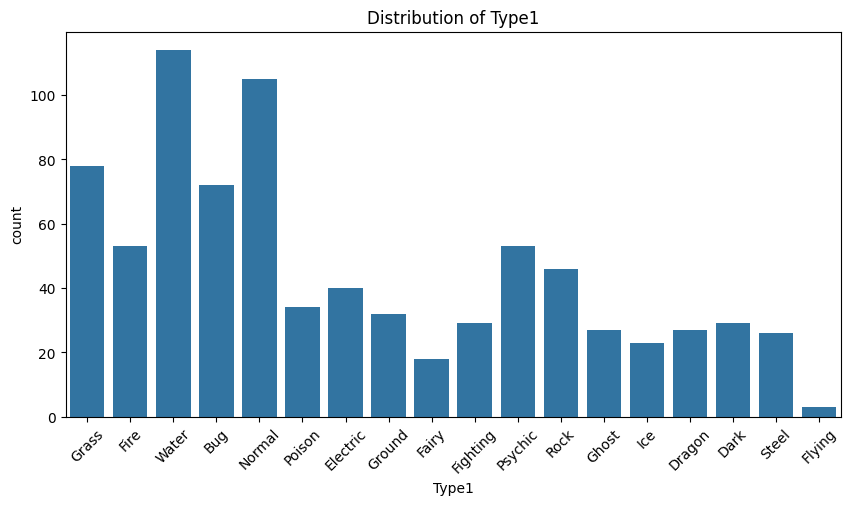

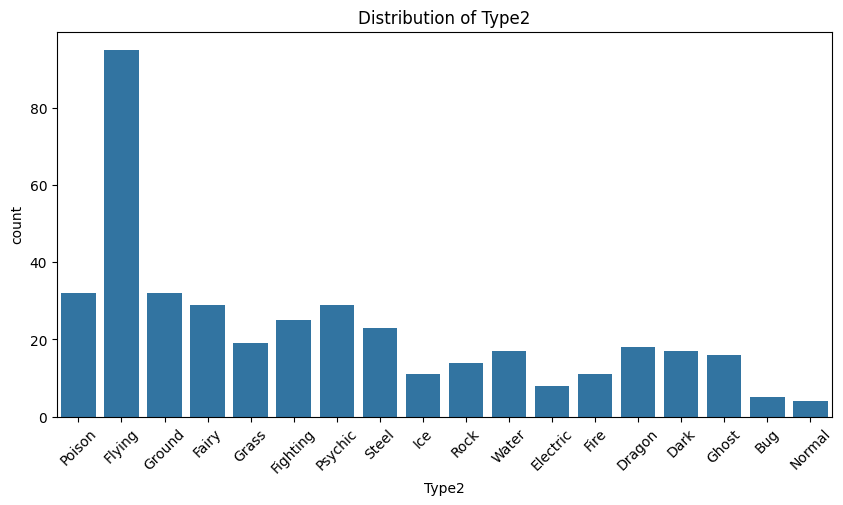

In [9]:

# Categorical Feature Analysis
# Explore counts of different categories
for column in types:
  plt.figure(figsize=(10, 5))
  sns.countplot(x=column, data=df)
  plt.xticks(rotation=45)
  plt.title(f"Distribution of {column}")
  plt.show()



Let's see the relationship between type 1 and type 2.

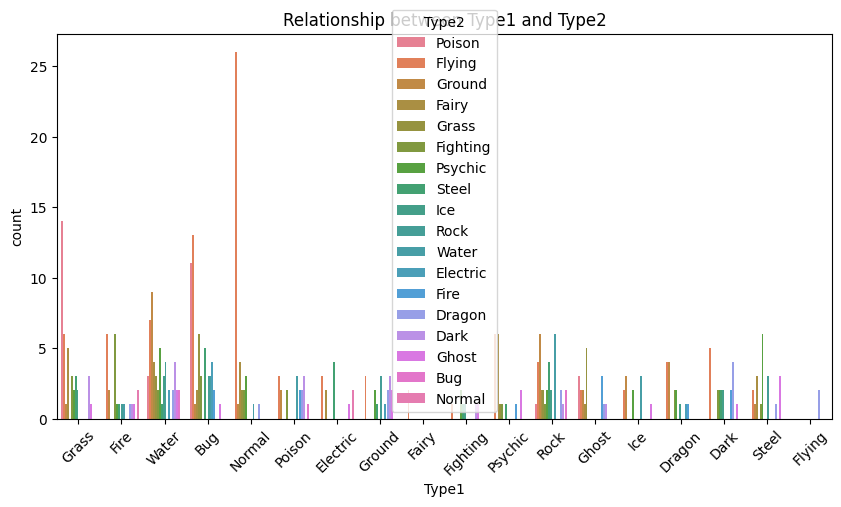

In [10]:
# Analyze the relationship between Type1 and Type2
plt.figure(figsize=(10, 5))
sns.countplot(x='Type1', hue='Type2', data=df)
plt.xticks(rotation=45)
plt.title("Relationship between Type1 and Type2")
plt.show()

And how many values in Type1 are present in Type2 and the opposite.

In [11]:
# Count how many Type1 values are present in Type2
type1_in_type2 = df['Type1'].isin(df['Type2']).sum()
print(f"Number of Type1 values present in Type2: {type1_in_type2}")

# Count how many Type2 values are present in Type1
type2_in_type1 = df['Type2'].isin(df['Type1']).sum()
print(f"Number of Type2 values present in Type1: {type2_in_type1}")


Number of Type1 values present in Type2: 809
Number of Type2 values present in Type1: 405


Let's see how many Pokemon are of every type.

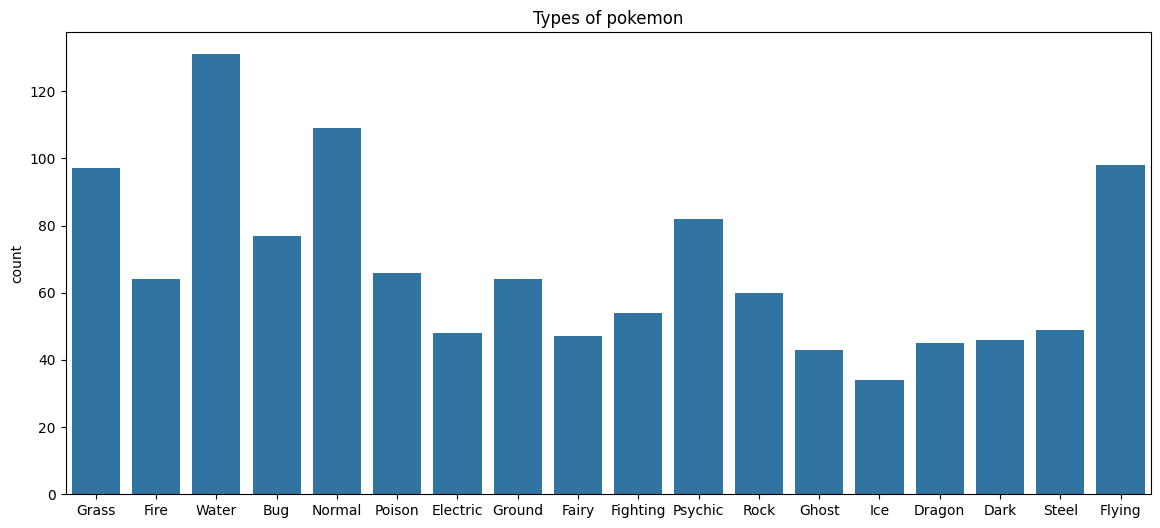

In [12]:
type1 = df['Type1'].tolist()
type2 = df['Type2'].tolist()

typo = type1 + type2

plt.figure(figsize=(14, 6))

sns.countplot(x=typo)
plt.title('Types of pokemon')
plt.show()

Because it's a very difficult question and it is very hard to find a Pokemon type only by looking at its picture, I will do these only for four types, the easier ones to find through photos.

In [13]:
allowed_types = ['Grass', 'Fire', 'Water', 'Rock']
df = df[df['Type1'].isin(allowed_types) & (df['Type2'].isin(allowed_types) | df['Type2'].isnull())]

In [14]:
df

,Name,Type1,Type2,Evolution
3,charmander,Fire,NaN,charmeleon
4,charmeleon,Fire,NaN,charizard
6,squirtle,Water,NaN,wartortle
7,wartortle,Water,NaN,blastoise
8,blastoise,Water,NaN,NaN
...,...,...,...,...
753,lurantis,Grass,NaN,NaN
760,bounsweet,Grass,NaN,NaN
761,steenee,Grass,NaN,NaN
762,tsareena,Grass,NaN,NaN


So we left with 157 Pokemons—a very challenging problem with such a small amount of data.
Let's make a column with a name type that is one of the allowed types.

In [15]:
allowed_types = ['Grass', 'Fire', 'Water', 'Rock']
df['type'] = np.nan

for index, row in df.iterrows():
  if row['Type1'] in allowed_types:
    df.loc[index, 'type'] = row['Type1']
  elif row['Type2'] in allowed_types:
    df.loc[index, 'type'] = row['Type2']

df

<ipython-input-15-e1be8a08543f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = np.nan
<ipython-input-15-e1be8a08543f>:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Fire' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'type'] = row['Type1']


,Name,Type1,Type2,Evolution,type
3,charmander,Fire,NaN,charmeleon,Fire
4,charmeleon,Fire,NaN,charizard,Fire
6,squirtle,Water,NaN,wartortle,Water
7,wartortle,Water,NaN,blastoise,Water
8,blastoise,Water,NaN,NaN,Water
...,...,...,...,...,...
753,lurantis,Grass,NaN,NaN,Grass
760,bounsweet,Grass,NaN,NaN,Grass
761,steenee,Grass,NaN,NaN,Grass
762,tsareena,Grass,NaN,NaN,Grass


Now, we drop the unwanted columns.

In [16]:

# Remove 'Type1', 'Type2', and 'Evolution' columns
df = df.drop(['Type1', 'Type2', 'Evolution'], axis=1)

df

,Name,type
3,charmander,Fire
4,charmeleon,Fire
6,squirtle,Water
7,wartortle,Water
8,blastoise,Water
...,...,...
753,lurantis,Grass
760,bounsweet,Grass
761,steenee,Grass
762,tsareena,Grass


We add a column of path where every Pokemon will have its picture path.

In [17]:
df['Image_Path'] = df['Name'].apply(lambda name: os.path.join(pic_dir, name + '.png'))

df

,Name,type,Image_Path
3,charmander,Fire,/content/images/charmander.png
4,charmeleon,Fire,/content/images/charmeleon.png
6,squirtle,Water,/content/images/squirtle.png
7,wartortle,Water,/content/images/wartortle.png
8,blastoise,Water,/content/images/blastoise.png
...,...,...,...
753,lurantis,Grass,/content/images/lurantis.png
760,bounsweet,Grass,/content/images/bounsweet.png
761,steenee,Grass,/content/images/steenee.png
762,tsareena,Grass,/content/images/tsareena.png


Let's add a plot of percentage of every Pokemon type.

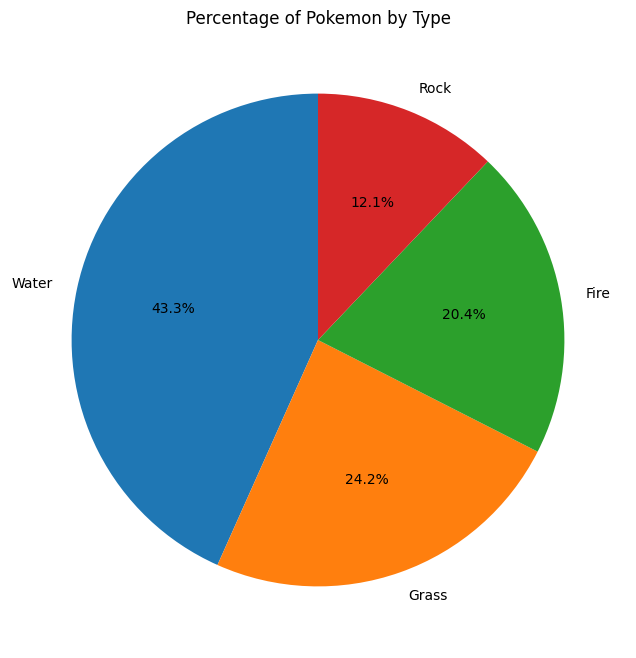

In [18]:
# Add a plot of the precentage of every type

# Calculate the percentage of each type
type_counts = df['type'].value_counts(normalize=True) * 100

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Pokemon by Type')
plt.show()

## Plan of Analysis

Based on our initial EDA, we plan to proceed with the following analysis:

* **Model Selection**: We will experiment with different CNN architectures, considering factors like complexity, computational requirements, and potential to address overfitting given our small dataset.
* **Hyperparameter Tuning**: Using cross-validation, we will optimize the model's hyperparameters (e.g., learning rate, batch size, number of epochs) to find the configuration that yields the best performance.
* **Class Imbalance**: We will consider methods to mitigate the effects of class imbalance identified through histograms, potentially employing oversampling, class weighting, or other strategies.
* **Performance Evaluation**: We will thoroughly evaluate the final model's performance on a held-out test set, focusing on key metrics like accuracy, precision, recall of each class.

# The model

We split the data frame to train validation and test 70%, 15%, and 15% with test data balanced between types.

In [19]:
# split the df to train validation and test 80%, 10%, 10% with test data balanced between types

from sklearn.model_selection import train_test_split

# Assuming 'df' is your dataframe and 'type' is the column containing the types

# Split the data into train+validation and test sets
train_val_df, test_df = train_test_split(df, test_size=0.3, stratify=df['type'], random_state=42)

# Split the train+validation set into train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.5, stratify=train_val_df['type'], random_state=42)  # 0.111 x 0.9 = 0.1


print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Check the distribution of types in each set
print("\nTrain set type distribution:")
print(train_df['type'].value_counts(normalize=True) * 100)
print("\nValidation set type distribution:")
print(val_df['type'].value_counts(normalize=True) * 100)
print("\nTest set type distribution:")
print(test_df['type'].value_counts(normalize=True) * 100)

Train set size: 54
Validation set size: 55
Test set size: 48

Train set type distribution:
type
Water    42.592593
Grass    24.074074
Fire     20.370370
Rock     12.962963
Name: proportion, dtype: float64

Validation set type distribution:
type
Water    43.636364
Grass    25.454545
Fire     20.000000
Rock     10.909091
Name: proportion, dtype: float64

Test set type distribution:
type
Water    43.750000
Grass    22.916667
Fire     20.833333
Rock     12.500000
Name: proportion, dtype: float64


We move all the pictures from train_df to a folder train and update the path in the df.

In [23]:




train_dir = '/content/train'
os.makedirs(train_dir, exist_ok=True)

def move_and_update_path(row):
  src_path = row['Image_Path']
  if os.path.exists(src_path):
    dst_path = os.path.join(train_dir, os.path.basename(src_path))
    shutil.move(src_path, dst_path)
    return dst_path
  else:
    return None

train_df['Image_Path'] = train_df.apply(move_and_update_path, axis=1)

train_df

,Name,type,Image_Path
0,tepig,Fire,/content/train/tepig.png
1,torchic,Fire,/content/train/torchic.png
2,tirtouga,Water,/content/train/tirtouga.png
3,chikorita,Grass,/content/train/chikorita.png
4,krabby,Water,/content/train/krabby.png
5,seedot,Grass,/content/train/seedot.png
6,simipour,Water,/content/train/simipour.png
7,chespin,Grass,/content/train/chespin.png
8,brionne,Water,/content/train/brionne.png
9,entei,Fire,/content/train/entei.png


Now, to handle the lack of data, we want to create 100 pictures for each picture in the training directory.

In [24]:
# Generate 100 more pictures from every picture save the pictures in the train_dir folder and update train_df with these pictures

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

new_train_df_rows = []

for index, row in train_df.iterrows():
    image_path = row['Image_Path']
    if image_path is not None and os.path.exists(image_path):
        try:
            img = Image.open(image_path)
            img = np.array(img)
            img = img.reshape((1,) + img.shape)

            i = 0
            for batch in datagen.flow(img, batch_size=1,
                                      save_to_dir=train_dir,
                                      save_prefix=row['Name'],
                                      save_format='png'):
                i += 1
                if i > 100:
                    break  # Generate 100 augmented images

                # Search for the saved image file in train_dir
                saved_image_name = None
                for filename in os.listdir(train_dir):
                    if filename.startswith(row['Name'] + '_') and filename.endswith('.png'):
                        saved_image_name = filename
                        break  # Found the saved image

                if saved_image_name:
                    new_image_path = os.path.join(train_dir, saved_image_name)
                    new_train_df_rows.append([row['Name'] + '_' + str(i), row['type'], new_image_path])
                    #print(f"Added: {new_image_path}")  # Confirmation message
                else:
                    print(f"Could not find saved image for {row['Name']}")

        except Exception as e:
            print(f"Error processing {image_path}: {e}")

new_rows_df = pd.DataFrame(new_train_df_rows, columns=['Name', 'type', 'Image_Path'])
train_df = pd.concat([train_df, new_rows_df], ignore_index=True)


Let's see how many files are now in our dataset.

In [25]:
# how many files are in train directory?

train_dir = '/content/train'
num_files = len([f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))])
print(f"Number of files in the train directory: {num_files}")

Number of files in the train directory: 5482


How many classes are available?

In [26]:
# how many classes are in type?

unique_types = val_df['type'].unique()
num_classes = len(unique_types)

print(f"Number of unique types (classes): {num_classes}")

Number of unique types (classes): 4


In [24]:
train_df

,Name,type,Image_Path
0,popplio,Water,/content/train/popplio.png
1,torkoal,Fire,/content/train/torkoal.png
2,lileep,Rock,/content/train/lileep.png
3,typhlosion,Fire,/content/train/typhlosion.png
4,seadra,Water,/content/train/seadra.png
...,...,...,...
8782,maractus_96,Grass,/content/train/maractus_0_2020.png
8783,maractus_97,Grass,/content/train/maractus_0_2020.png
8784,maractus_98,Grass,/content/train/maractus_0_2020.png
8785,maractus_99,Grass,/content/train/maractus_0_2020.png


How many pixels are in every picture? This is important for the model's first layer.

In [27]:
# Open the image using PIL
img = Image.open(train_df['Image_Path'].iloc[456])

# Get the width and height of the image
width, height = img.size

print(f"Image pixel size: {width}x{height}")

Image pixel size: 120x120


Now, checking if all pictures are the same size is essential.

In [28]:
incorrect_size_count = 0

for filename in os.listdir(train_dir):
  if filename.endswith(".png"):
    image_path = os.path.join(train_dir, filename)
    try:
      img = Image.open(image_path)
      width, height = img.size
      if width != 120 or height != 120:
        incorrect_size_count += 1
        print(f"Image {filename} has incorrect size: {width}x{height}")
    except Exception as e:
      print(f"Error processing image {filename}: {e}")

if incorrect_size_count == 0:
  print("All images in the directory have the correct size (120x120).")
else:
  print(f"{incorrect_size_count} images in the directory have incorrect size.")

All images in the directory have the correct size (120x120).


In this section, we will try three different models: a basic CNN, an advanced CNN with more layers, dropout, and data augmentation. The third part would take a pre-trained model and fine-tune it to fit the task. We will also try different learning rates, data augmentation, and preprocessing techniques to see how these techniques influence the results.

**Why we use this layers?**

*Convolutional Layers* -  These layers are the core building blocks of a CNN. They apply a set of learnable filters to the input image to extract features.

*Max Pooling Layers*: These layers reduce the spatial dimensions of the feature maps output by the convolutional layers.

*Dropout Layers*: These layers randomly deactivate a fraction of the neurons during training. The reason is Overfitting Prevention.

Let's try a basic CNN model.

In [29]:


def create_basic_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(120, 120, 3)),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        # Change the output layer to match the number of classes (5 in this case)
        Dense(4, activation='softmax')
    ])
    return model

basic_model = create_basic_model()
basic_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 118, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,442,564 (24.58 MB)

 Trainable params: 6,442,564 (24.58 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='Image_Path',  # Use the new 'Image_Path' column
    y_col='type',
    target_size=(120, 120),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=pic_dir,
    x_col='Image_Path',  # Use the new 'Image_Path' column
    y_col='type',
    target_size=(120, 120),
    batch_size=32,
    class_mode='categorical'
)

Found 5454 validated image filenames belonging to 4 classes.
Found 55 validated image filenames belonging to 4 classes.


In [29]:
basic_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [30]:
history_basic_model = basic_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - acc: 0.7787 - loss: 0.5868 - val_acc: 0.7632 - val_loss: 1.3592
Epoch 2/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - acc: 0.9826 - loss: 0.0718 - val_acc: 0.7368 - val_loss: 1.8549
Epoch 3/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - acc: 0.9914 - loss: 0.0351 - val_acc: 0.6053 - val_loss: 1.2505
Epoch 4/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - acc: 0.9963 - loss: 0.0177 - val_acc: 0.6053 - val_loss: 1.5764
Epoch 5/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - acc: 0.9939 - loss: 0.0232 - val_acc: 0.6053 - val_loss: 1.4690
Epoch 6/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - acc: 0.9978 - loss: 0.0087 - val_acc: 0.5789 - val_loss: 2.1874
Epoch 7/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - acc: 0.9973 - loss: 0.0121 - val_acc: 0.6316 - val_loss: 2.2255
Epoch 8/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - acc: 0.9971 - loss: 0.0078 - val_acc: 0.6053 - val_loss: 1.9714
Epoch 9/20
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step 

No, let's plot the accuracy and loss graph.

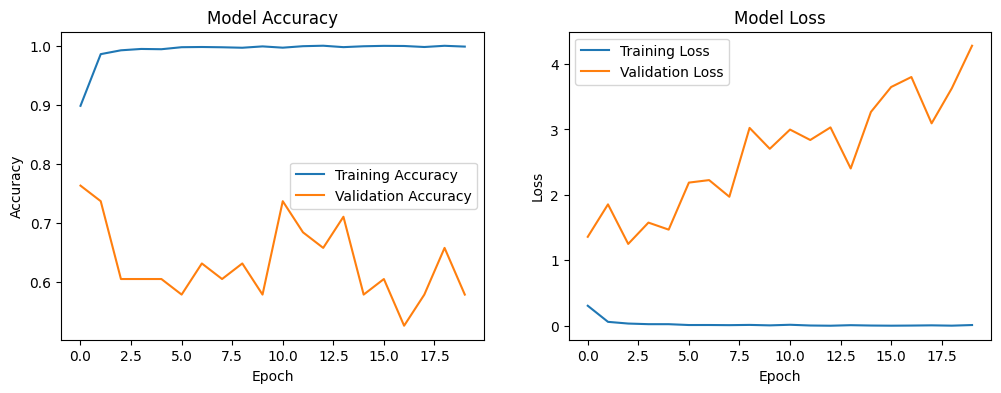

In [31]:
# prompt: could you plot the accurasiy and loss grpah threw the inarations?

# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_basic_model.history['acc'], label='Training Accuracy')
plt.plot(history_basic_model.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_basic_model.history['loss'], label='Training Loss')
plt.plot(history_basic_model.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

We can see that the learning is great, but the model is highly overfitting.
The next step is a more advanced model with regulation and more layers.

In [32]:
def create_advanced_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu',kernel_regularizer=l2(0.01), input_shape=(120, 120, 3)),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Dropout(0.2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model

advanced_model = create_advanced_model()
advanced_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 118, 118, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 57, 57, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 26, 26, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       5,538,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,632,324 (21.49 MB)

 Trainable params: 5,632,324 (21.49 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
advanced_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [34]:
history_advanced = advanced_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - acc: 0.6542 - loss: 0.9151 - val_acc: 0.7632 - val_loss: 1.5780
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - acc: 0.9471 - loss: 0.2158 - val_acc: 0.7105 - val_loss: 1.5596
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - acc: 0.9787 - loss: 0.1189 - val_acc: 0.7105 - val_loss: 1.2913
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - acc: 0.9838 - loss: 0.0980 - val_acc: 0.7368 - val_loss: 1.3228
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - acc: 0.9904 - loss: 0.0697 - val_acc: 0.6842 - val_loss: 1.8173
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - acc: 0.9895 - loss: 0.0631 - val_acc: 0.7105 - val_loss: 1.6248
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - acc: 0.9925 - loss: 0.0585 - val_acc: 0.7632 - val_loss: 2.0675
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - acc: 0.9893 - loss: 0.0616 - val_acc: 0.7632 - val_loss: 1.5297
Epoch 9/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 1

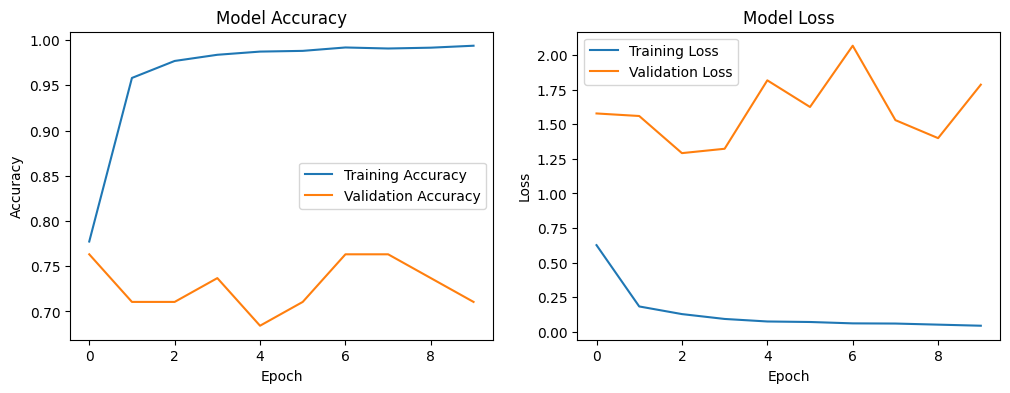

In [35]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_advanced.history['acc'], label='Training Accuracy')
plt.plot(history_advanced.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_advanced.history['loss'], label='Training Loss')
plt.plot(history_advanced.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The results are better, but the model is still overfitting.

Now let's try to fine-tune a SOTA model.

In [36]:


# Freeze the base model layers:

base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

for layer in base_model.layers:
    layer.trainable = False

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [37]:
# Add a custom classification head

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Add a dense layer for feature extraction
predictions = Dense(4, activation='softmax')(x)  # Output layer for binary classification

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [39]:
# Train the model using the data generator
history = model.fit(train_generator, epochs=10, validation_data=val_generator)  # Adjust epochs as needed

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 95s 192ms/step - acc: 0.4066 - loss: 1.3085 - val_acc: 0.4211 - val_loss: 1.3033
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - acc: 0.4402 - loss: 1.2817 - val_acc: 0.4211 - val_loss: 1.3054
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - acc: 0.4268 - loss: 1.2933 - val_acc: 0.4211 - val_loss: 1.3024
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - acc: 0.4363 - loss: 1.2807 - val_acc: 0.4211 - val_loss: 1.3011
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - acc: 0.4403 - loss: 1.2795 - val_acc: 0.4211 - val_loss: 1.3106
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - acc: 0.4361 - loss: 1.2877 - val_acc: 0.4211 - val_loss: 1.3005
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - acc: 0.4442 - loss: 1.2738 - val_acc: 0.4211 - val_loss: 1.3125
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - acc: 0.4382 - loss: 1.2791 - val_acc: 0.4211 - val_loss: 1.3025
Epoch 9/10
275/275 ━━━━━━━━━━━━━━━━━━━━

In [40]:
for layer in base_model.layers[-10:]:  # Example: unfreeze the last 10 layers
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_generator, epochs=10, validation_data=val_generator)  # Adjust epochs as needed

Epoch 1/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 91s 174ms/step - acc: 0.3542 - loss: 1.5586 - val_acc: 0.4211 - val_loss: 1.3188
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - acc: 0.4357 - loss: 1.2853 - val_acc: 0.4211 - val_loss: 1.3023
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - acc: 0.4345 - loss: 1.2851 - val_acc: 0.4211 - val_loss: 1.3020
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - acc: 0.4472 - loss: 1.2721 - val_acc: 0.4211 - val_loss: 1.3046
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - acc: 0.4308 - loss: 1.2858 - val_acc: 0.4211 - val_loss: 1.3016
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - acc: 0.4327 - loss: 1.2846 - val_acc: 0.4211 - val_loss: 1.3011
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - acc: 0.4415 - loss: 1.2799 - val_acc: 0.4211 - val_loss: 1.3051
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - acc: 0.4354 - loss: 1.2815 - val_acc: 0.4211 - val_loss: 1.3047
Epoch 9/10
275/275 ━━━━━━━━━━━━━━━━━━━━

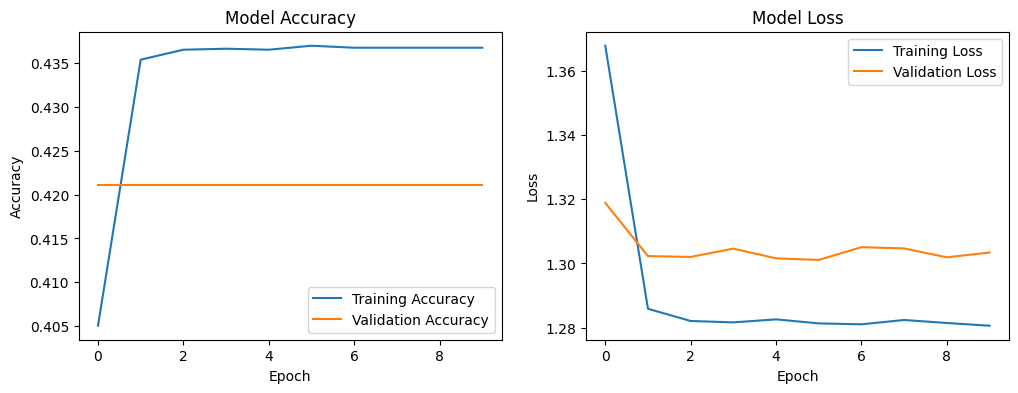

In [42]:
# prompt: could you plot the accurasiy and loss grpah threw the inarations?

# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

The results are terrible. It's much worse than the basic model.

The last step is to try hyperparameter tuning to reach better results.

In [31]:


def build_model(hp):
    """Builds a model with hyperparameters defined by hp."""
    model = Sequential()

    # First convolutional block with tunable filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_reg_1', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        input_shape=(120, 120, 3)
    ))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    # Second convolutional block with tunable filters and kernel size
    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    # Fully connected layers with tunable units and dropout
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units_1', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(Dense(4, activation='softmax'))

    # Compile the model with tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['acc']
    )
    return model

# Create a tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_acc',  # Optimize for validation accuracy
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=2, # Number of models to train for each combination
    directory='my_dir',  # Directory to save the results
    project_name='pokemon_classification'
)







/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# Search for the best hyperparameters
tuner.search(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Trial 10 Complete [00h 05m 55s]
val_acc: 0.7181818187236786

Best val_acc So Far: 0.7272727489471436
Total elapsed time: 00h 40m 14s


In [33]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model using the best hyperparameters
best_model = build_model(best_hps)

In [34]:
# Train the best model on the full training data
history_best = best_model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - acc: 0.4935 - loss: 1.2475 - val_acc: 0.5455 - val_loss: 1.3857
Epoch 2/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - acc: 0.9439 - loss: 0.1958 - val_acc: 0.5091 - val_loss: 1.6922
Epoch 3/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - acc: 0.9758 - loss: 0.0985 - val_acc: 0.6545 - val_loss: 1.5979
Epoch 4/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - acc: 0.9855 - loss: 0.0711 - val_acc: 0.6182 - val_loss: 1.8250
Epoch 5/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - acc: 0.9921 - loss: 0.0420 - val_acc: 0.7091 - val_loss: 1.6621
Epoch 6/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - acc: 0.9947 - loss: 0.0362 - val_acc: 0.6000 - val_loss: 1.9285
Epoch 7/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - acc: 0.9940 - loss: 0.0302 - val_acc: 0.7091 - val_loss: 2.1638
Epoch 8/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - acc: 0.9939 - loss: 0.0322 - val_acc: 0.6727 - val_loss: 2.5894
Epoch 9/20
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 52m

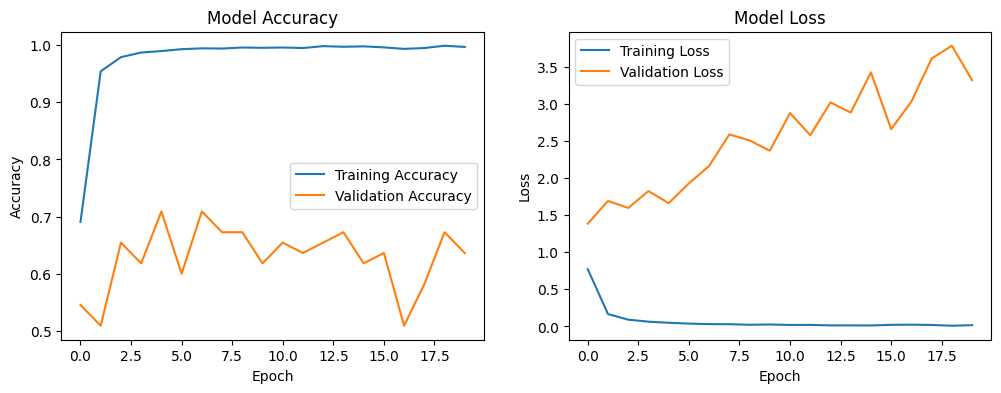

In [35]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_best.history['acc'], label='Training Accuracy')
plt.plot(history_best.history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_best.history['loss'], label='Training Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Found 48 validated image filenames belonging to 4 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.5625 - loss: 4.7339

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - acc: 0.5764 - loss: 4.3103
Test Loss: 4.0985
Test Accuracy: 0.5833
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
              precision    recall  f1-score   support

        Fire       0.53      0.90      0.67        10
       Grass       0.73      0.73      0.73        11
        Rock       0.33      0.17      0.22         6
       Water       0.59      0.48      0.53        21

    accuracy                           0.58        48
   macro avg       0.54      0.57      0.54        48
weighted avg       0.58      0.58      0.56        48



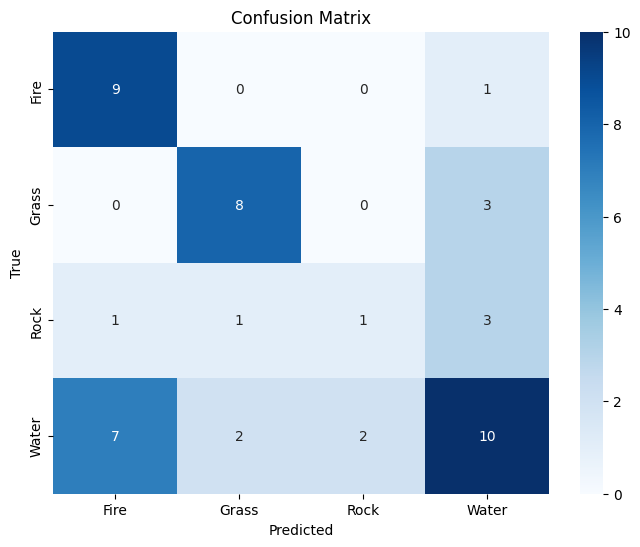

In [36]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=pic_dir,
    x_col='Image_Path',
    y_col='type',
    target_size=(120, 120),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important: Don't shuffle for evaluation
)

# Evaluate the model on the test data
loss, accuracy = best_model.evaluate(test_generator)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Get predictions on the test set
y_pred = best_model.predict(test_generator)
y_true = test_generator.classes

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

# Generate the classification report
print(classification_report(y_true, y_pred_labels, target_names=test_generator.class_indices.keys()))

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Discussion: CNN Performance and Data Considerations


In this project, we investigated the effectiveness of Convolutional Neural Networks for Pokemon type detection. We implemented and evaluated various CNN architectures, observing notable performance variations, which can be attributed to the interplay between model complexity, the nature of our dataset, and the challenges posed by limited data.

**CNN Architecture Complexity and Generalization:**

CNNs with deeper architectures and a larger number of layers and parameters generally have a higher capacity to learn complex features and patterns. However, this complexity increases their susceptibility to overfitting, especially when training data is limited. In the context of our Pokemon type detection task, with a relatively small dataset, we observed that shallower CNN architectures with fewer layers tended to perform better than their deeper counterparts. This suggests that simpler architectures were better suited to our data constraints, as they were less prone to memorizing the training data and more capable of generalizing learned patterns to unseen Pokemon images.

**Feature Extraction and Representation:**

CNNs excel at automatically learning relevant features from images. However, the effectiveness of feature extraction is heavily influenced by the architecture's design. Different CNN architectures employ varying kernel sizes, strides, and pooling operations, leading to different feature representations. For our Pokemon type detection task, architectures that effectively captured distinctive features, such as edges, shapes, and color patterns relevant to Pokemon types, likely achieved better performance. We observed that our small tooned network were more adept at extracting discriminative features, resulting in improved classification accuracy.

**Hyperparameter Tuning and Regularization:**

Hyperparameter optimization and regularization techniques played a crucial role in mitigating overfitting and improving CNN performance. We experimented with different hyperparameter settings, including learning rates, batch sizes, and the number of epochs, to find optimal configurations for each architecture. Additionally, we employed regularization techniques like dropout and weight decay to constrain model complexity and prevent overfitting. Fine-tuning hyperparameters and applying regularization helped to strike a balance between model expressiveness and generalization, ultimately leading to better performance on our limited dataset.

**Data Augmentation and Transfer Learning:**

Data augmentation techniques were essential for artificially expanding our dataset and enhancing model robustness. We employed transformations such as rotations, flips, and color adjustments to generate variations of existing Pokemon images, effectively increasing the diversity of our training data. This augmentation helped to reduce overfitting and improve the CNN's ability to generalize to new Pokemon images. Transfer learning was employed in this project, but as we can see the results of the model was not good enough.

# Conclusion
This project aimed to develop a model for detecting Pokemon types based on their images using various deep learning techniques. Several models were experimented with, including CNNs, transfer learning with pre-trained architecture and data augmentation techniques.

**Results and Interpretation:**

Interestingly, while transfer learning with pre-trained models was explored, it did not yield the best results. The highest accuracy was achieved by a fine-tuned network trained specifically for Pokemon type detection. This suggests that the pre-trained models, despite their knowledge of general image features, may not have been optimally suited for the nuances of Pokemon image classification. Data augmentation, however, played a crucial role in enhancing model generalization and robustness, regardless of the model architecture. The main resune for this was the lack of data.

**Learnings and Takeaways:**

* Data augmentation is essential: Augmenting the dataset with variations helped to prevent overfitting and improve the model's ability to handle diverse Pokemon images. This was evident across different model architectures, highlighting the importance of data augmentation as a general practice.
* Pre-trained models may not always be the best: The project highlights that pre-trained models, despite their usefulness, may not always be the best solution, and task-specific training could be necessary for superior performance.

**What did and did not help improve the performance:**

* Helped: Fine-tuning a network specifically trained for Pokemon type detection and data augmentation contributed to significant performance improvements.
* Did not help: Transfer learning using pre-trained models as is, without extensive fine-tuning, did not yield the best results. This is evident from the lower accuracy scores observed in your notebook.

**Future Improvements:**

* Advanced fine-tuning techniques: Explore more sophisticated fine-tuning strategies, such as layer-wise fine-tuning or gradual unfreezing, to further optimize the models.
* Hyperparameter optimization: Conduct extensive hyperparameter optimization to identify the ideal settings for the best-performing architecture.
* Larger and more diverse dataset: Collecting a larger and more diverse dataset is always beneficial for deep learning models.
* Ensemble methods: Combining the predictions of multiple models could improve accuracy and robustness.
* Addressing class imbalance: Some Pokemon types might be under-represented in the dataset, leading to biased predictions. Addressing this imbalance could improve performance.